<a href="https://colab.research.google.com/github/TristanChanCraig/Gesture-Recognition-Using-MediaPipe-and-OpenCV/blob/main/Gesture_Recognition_Using_MediaPipe_and_OpenCV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q mediapipe
!wget -q https://storage.googleapis.com/mediapipe-models/gesture_recognizer/gesture_recognizer/float16/1/gesture_recognizer.task # Mediapipe's Gesture Recognition Model

In [ ]:

from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

filename = None
def take_photo(filename='photo.jpg', quality=0.9):  # Colab's Capture Video Script
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);
      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
      await new Promise((resolve) => capture.onclick = resolve);
      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


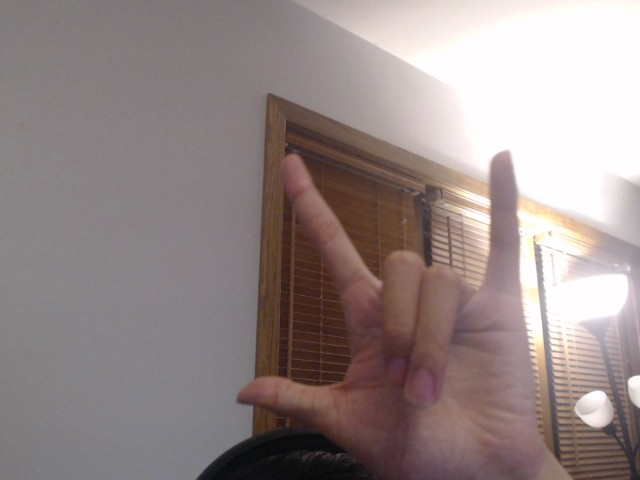

In [ ]:
from IPython.display import Image
try:
  f = take_photo()
  print('Saved to {}'.format(f))
  display(Image(f))
  filename = f
except Exception as err:
  print(str(err))

In [ ]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

BaseOptions = mp.tasks.BaseOptions
GestureRecognizer = mp.tasks.vision.GestureRecognizer
GestureRecognizerOptions = mp.tasks.vision.GestureRecognizerOptions
VisionRunningMode = mp.tasks.vision.RunningMode

options = GestureRecognizerOptions(
    base_options=BaseOptions(model_asset_path='gesture_recognizer.task'),
    running_mode=VisionRunningMode.IMAGE)
recognizer = GestureRecognizer.create_from_options(options)



In [ ]:
from matplotlib import pyplot as plt
from mediapipe.framework.formats import landmark_pb2
import math

plt.rcParams.update({
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.spines.left': False,
    'axes.spines.bottom': False,
    'xtick.labelbottom': False,
    'xtick.bottom': False,
    'ytick.labelleft': False,
    'ytick.left': False,
    'xtick.labeltop': False,
    'xtick.top': False,
    'ytick.labelright': False,
    'ytick.right': False
})

mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles


def display_one_image(image, title, subplot, titlesize=16):
    """Displays one image along with the predicted category name and score."""
    plt.subplot(*subplot)
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize), color='black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)


def display_batch_of_images_with_gestures_and_hand_landmarks(images, results):  # Mediapipe's Display Image Function
    """Displays a batch of images with the gesture category and its score along with the hand landmarks."""

    images = [image.numpy_view() for image in images]
    gestures = [top_gesture for (top_gesture, _) in results]
    multi_hand_landmarks_list = [multi_hand_landmarks for (_, multi_hand_landmarks) in results]


    rows = int(math.sqrt(len(images)))
    cols = len(images) // rows


    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols, 1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))

    for i, (image, gestures) in enumerate(zip(images[:rows*cols], gestures[:rows*cols])):
        title = f"{gestures.category_name} ({gestures.score:.2f})"
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols) * 40 + 3
        annotated_image = image.copy()

        for hand_landmarks in multi_hand_landmarks_list[i]:
          hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
          hand_landmarks_proto.landmark.extend([
            landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
          ])

          mp_drawing.draw_landmarks(
            annotated_image,
            hand_landmarks_proto,
            mp_hands.HAND_CONNECTIONS,
            mp_drawing_styles.get_default_hand_landmarks_style(),
            mp_drawing_styles.get_default_hand_connections_style())

        subplot = display_one_image(annotated_image, title, subplot, titlesize=dynamic_titlesize)


    plt.tight_layout()
    plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()



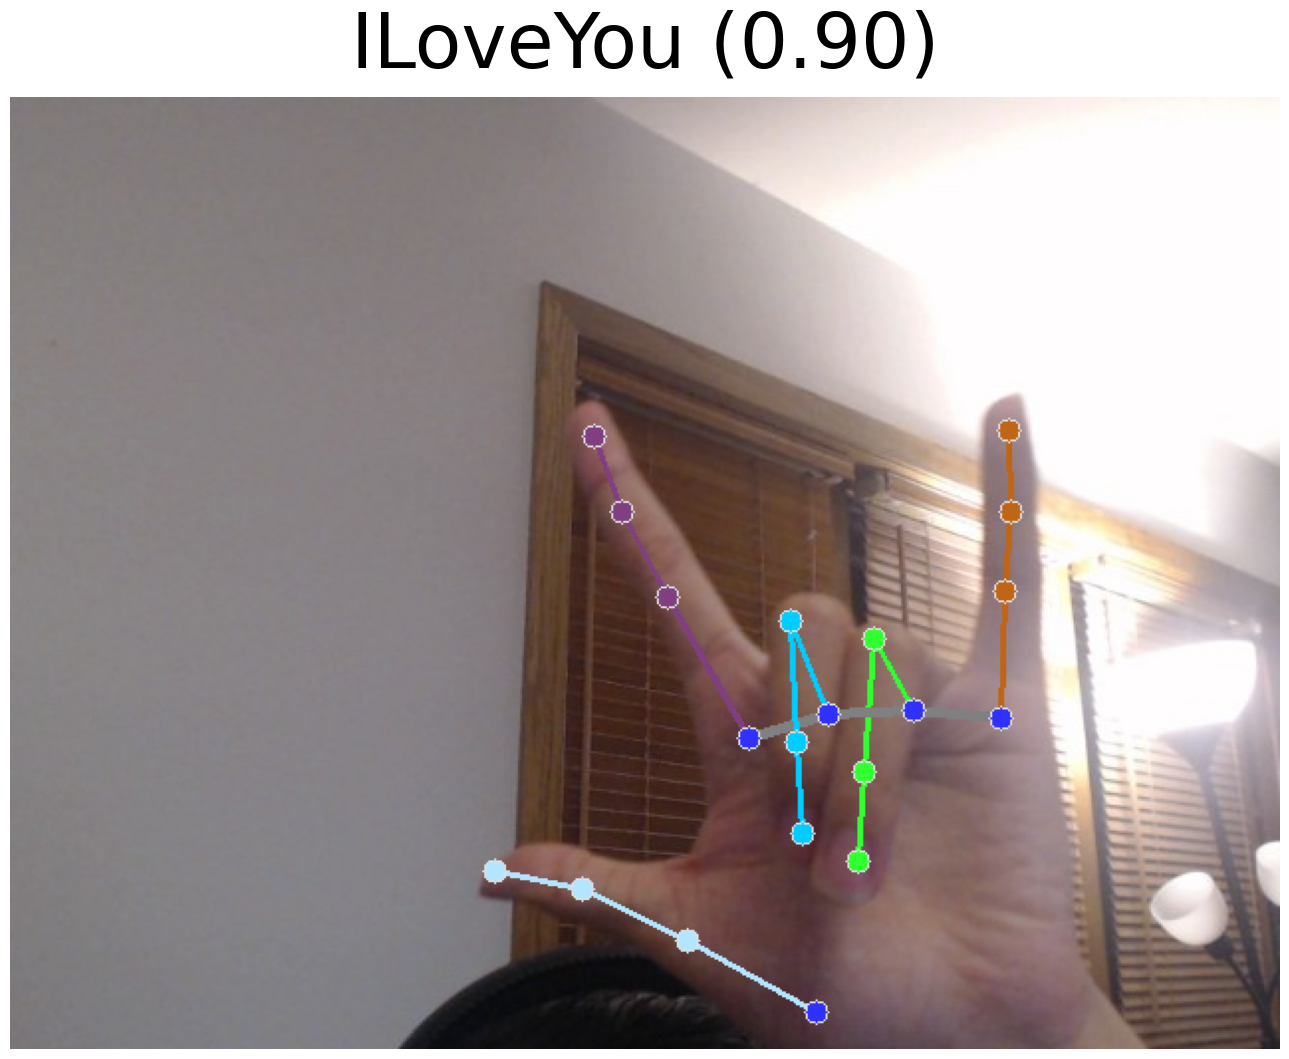

In [ ]:
try:
  images = []
  results = []
  image = mp.Image.create_from_file(filename)
  recognition_result = recognizer.recognize(image)
  images.append(image)
  top_gesture = recognition_result.gestures[0][0]
  hand_landmarks = recognition_result.hand_landmarks
  results.append((top_gesture, hand_landmarks))
  display_batch_of_images_with_gestures_and_hand_landmarks(images, results)
except Exception as err:
  print(str(err))
